# LinkedIn Engagement Modeling Experiments

This notebook explores alternative targets and feature sets for predicting LinkedIn post performance, focusing on reducing follower dominance and comparing content-only vs content+influencer models.

We will:
- Engineer multiple target formulations (rates, logs, within-creator scores)
- Build simple baselines and ML models
- Compare content-only vs content+influencer features
- Produce a practical, follower-robust content scoring signal.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

print("✓ Libraries imported")

✓ Libraries imported


In [2]:
# 1. Data loading & sanity checks
INPUT_FILE = "../data/selected_features_data.csv"

df = pd.read_csv(INPUT_FILE)
print(f"Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")

print("\nPreview:")
display(df.head())

print("\nMissing values (top 20):")
missing = df.isna().sum().sort_values(ascending=False)
print(missing.head(20))

Dataset loaded: 772 rows × 94 columns

Preview:


,name,content,reactions,comments,time_spent,location,followers,influencer_avg_comments,reactions_per_sentiment,influencer_avg_engagement,...,is_promotional,has_hidden_truth,hook_x_power_score,has_org_mention,hook_score,ner_event_count,has_announcement_hook,has_specific_time_content,has_recency_hook,has_underdog
0,kevinswiber,I’m not famous. I’m not even popular. But I ha...,65.0,8.00,5,NaN,3690,8.00,125.920186,73.00,...,0,0,0,0,0,0,0,0,0,0
1,puneet-bhardwaj-849aa01,AI at the speed of light! While researching th...,34.0,2.00,3,NaN,2546,2.00,36.496350,36.00,...,0,0,0,1,0,0,0,0,0,0
2,jainnitin1983,I wanted to share that I’ve decided to move on...,34.0,5.00,1,NaN,3888,5.00,34.665579,39.00,...,0,0,0,1,0,0,0,0,0,0
3,zuzar-tinwalla-a4b9a423,After 39 incredible years in the BFS industry ...,2485.0,528.58,3,NaN,12500,528.58,2522.842640,3013.58,...,0,0,0,1,0,0,0,0,0,0
4,kinlane,To all the people who complained I've been too...,38.0,5.00,1,NaN,12818,4.50,68.173663,33.00,...,0,0,0,0,0,0,0,0,0,0



Missing values (top 20):
location                       772
name                             0
content                          0
reactions                        0
comments                         0
time_spent                       0
followers                        0
influencer_avg_comments          0
reactions_per_sentiment          0
influencer_avg_engagement        0
comments_vs_influencer_avg       0
reactions_vs_influencer_avg      0
influencer_total_engagement      0
reactions_per_word               0
comments_per_word                0
sentiment_compound               0
text_difficult_words_count       0
total_engagement_elements        0
readability_flesch_kincaid       0
comment_to_reaction_ratio        0
dtype: int64


In [3]:
# 2. Target engineering: multiple notions of performance

# Safe followers to avoid divide-by-zero
followers_safe = np.where(df["followers"] > 0, df["followers"], 1)

# Rate-based targets (engagement rate)
df["reactions_rate"] = df["reactions"] / followers_safe
df["comments_rate"] = df["comments"] / followers_safe

# Log-transformed raw counts (stabilize heavy tails)
df["log_reactions"] = np.log1p(df["reactions"])
df["log_comments"] = np.log1p(df["comments"])

# Within-creator normalized scores (z-scores and percentiles)
creator_col = "name"  # creator identifier

# Compute per-creator statistics
creator_stats = df.groupby(creator_col).agg({
    "reactions_rate": ["mean", "std"],
    "comments_rate": ["mean", "std"],
    "reactions": ["mean"],
    "comments": ["mean"]
})
creator_stats.columns = ["_".join(col).strip() for col in creator_stats.columns.values]

# Map back to rows
for col in creator_stats.columns:
    df[f"creator_{col}"] = df[creator_col].map(creator_stats[col])

# Z-scores (within-creator performance)
for base_col in ["reactions_rate", "comments_rate"]:
    mean_col = f"creator_{base_col}_mean"
    std_col = f"creator_{base_col}_std"
    z_col = f"{base_col}_z_within_creator"
    df[z_col] = (df[base_col] - df[mean_col]) / df[std_col].replace(0, np.nan)

# Percentile ranks within creator
for base_col in ["reactions_rate", "comments_rate"]:
    pct_col = f"{base_col}_pct_within_creator"
    def _percentile_within_creator(x):
        return x.rank(pct=True)
    df[pct_col] = df.groupby(creator_col)[base_col].transform(_percentile_within_creator)

print("Engineered targets and within-creator statistics.")

# Correlation of different targets with followers
target_cols = [
    "reactions", "comments",
    "reactions_rate", "comments_rate",
    "log_reactions", "log_comments",
    "reactions_rate_z_within_creator", "comments_rate_z_within_creator",
    "reactions_rate_pct_within_creator", "comments_rate_pct_within_creator",
]

print("\nCorrelation of targets with followers:")
for col in target_cols:
    if col in df.columns:
        corr = df[col].corr(df["followers"])
        print(f"  {col:35s} -> corr with followers: {corr: .3f}")

Engineered targets and within-creator statistics.

Correlation of targets with followers:
  reactions                           -> corr with followers:  0.347
  comments                            -> corr with followers:  0.298
  reactions_rate                      -> corr with followers: -0.112
  comments_rate                       -> corr with followers: -0.093
  log_reactions                       -> corr with followers:  0.379
  log_comments                        -> corr with followers:  0.386
  reactions_rate_z_within_creator     -> corr with followers:  0.000
  comments_rate_z_within_creator      -> corr with followers: -0.000
  reactions_rate_pct_within_creator   -> corr with followers: -0.230
  comments_rate_pct_within_creator    -> corr with followers: -0.235


In [4]:
# 3. Evaluation metrics (including sMAPE)

def symmetric_mape(y_true, y_pred):
    """Symmetric MAPE - handles zeros properly."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    denom = np.where(denom == 0, 1, denom)
    return np.mean(2.0 * np.abs(y_true - y_pred) / denom) * 100


def evaluate_model(y_true, y_pred, model_name="model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    smape = symmetric_mape(y_true, y_pred)
    medae = np.median(np.abs(y_true - y_pred))
    return {
        "model": model_name,
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
        "smape": smape,
        "medae": medae,
    }

print("✓ Evaluation metrics ready")

✓ Evaluation metrics ready


In [5]:
# 4. Baseline models (global and per-creator)

# Choose a primary target for baselines and modeling
TARGET_COL = "reactions_rate"  # you can change this to try others

# Single split so all targets share the same train/test indices
indices = np.arange(len(df))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_df = df.iloc[train_idx].copy()
test_df = df.iloc[test_idx].copy()

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

baseline_results = []

# Global mean baseline
global_mean = train_df[TARGET_COL].mean()
y_true = test_df[TARGET_COL].values
y_pred = np.full_like(y_true, fill_value=global_mean, dtype=float)

metrics = evaluate_model(y_true, y_pred, model_name=f"Global mean ({TARGET_COL})")
baseline_results.append(metrics)
print("\nGlobal mean baseline:")
print(metrics)

# Per-creator mean baseline (fallback to global mean if unseen creator)
creator_means = train_df.groupby(creator_col)[TARGET_COL].mean()

def predict_creator_mean(row):
    name = row[creator_col]
    if name in creator_means.index:
        return creator_means.loc[name]
    return global_mean

y_pred_creator = test_df.apply(predict_creator_mean, axis=1).values
metrics = evaluate_model(y_true, y_pred_creator, model_name=f"Per-creator mean ({TARGET_COL})")
baseline_results.append(metrics)

print("\nPer-creator mean baseline:")
print(metrics)

print("\nBaseline comparison:")
print(pd.DataFrame(baseline_results))

Train size: 617, Test size: 155

Global mean baseline:
{'model': 'Global mean (reactions_rate)', 'mae': 0.03268706231947962, 'rmse': np.float64(0.05888185184844699), 'r2': -0.0074989865588197535, 'smape': np.float64(132.7333972643575), 'medae': np.float64(0.027234224513638727)}

Per-creator mean baseline:
{'model': 'Per-creator mean (reactions_rate)', 'mae': 0.02612156238121698, 'rmse': np.float64(0.05946273896574138), 'r2': -0.02747559949539169, 'smape': np.float64(99.77548993412839), 'medae': np.float64(0.016618497109826588)}

Baseline comparison:
                               model       mae      rmse        r2  \
0       Global mean (reactions_rate)  0.032687  0.058882 -0.007499   
1  Per-creator mean (reactions_rate)  0.026122  0.059463 -0.027476   

        smape     medae  
0  132.733397  0.027234  
1   99.775490  0.016618  


In [6]:
# 5. Feature sets: content-only vs content+influencer

LEAKAGE_FEATURES = [
    "reactions_per_sentiment",
    "reactions_per_word",
    "comments_per_word",
    "reactions_vs_influencer_avg",
    "comments_vs_influencer_avg",
    "comment_to_reaction_ratio",
]

INFLUENCER_FEATURES = [
    "followers",
    "influencer_post_count",
    "influencer_std_reactions",
    "influencer_consistency_reactions",
    "influencer_std_comments",
    "influencer_avg_engagement",
    "influencer_total_engagement",
    "influencer_consistency_reactions",
    "influencer_avg_sentiment",
    "influencer_avg_base_score",
    "influencer_avg_comments",
    "influencer_avg_reactions",
    "influencer_median_reactions",
    "influencer_median_comments",
]

# Metadata / target columns to exclude from features
metadata_cols = ["name", "slno", "content", "time_spent", "location"]

engineered_target_cols = [
    "reactions", "comments",
    "reactions_rate", "comments_rate",
    "log_reactions", "log_comments",
    "reactions_rate_z_within_creator", "comments_rate_z_within_creator",
    "reactions_rate_pct_within_creator", "comments_rate_pct_within_creator",
]

exclude_cols = set(metadata_cols + LEAKAGE_FEATURES + engineered_target_cols + INFLUENCER_FEATURES)

# All numeric columns eligible for content features
numeric_cols = [
    c for c in df.columns
    if df[c].dtype in [np.float64, np.int64, np.int32] and c not in exclude_cols
]

CONTENT_FEATURES = sorted(numeric_cols)

# Full feature set adds influencer features that exist in the data
influencer_cols_present = [c for c in INFLUENCER_FEATURES if c in df.columns]
FULL_FEATURES = CONTENT_FEATURES + influencer_cols_present

print(f"Content-only features: {len(CONTENT_FEATURES)}")
print(f"Influencer features present: {len(influencer_cols_present)}")
print(f"Full feature set size: {len(FULL_FEATURES)}")

X_content = df.loc[:, CONTENT_FEATURES].fillna(0)
X_full = df.loc[:, FULL_FEATURES].fillna(0)

y = df[TARGET_COL].values

X_content_train = X_content.iloc[train_idx].values
X_content_test = X_content.iloc[test_idx].values

X_full_train = X_full.iloc[train_idx].values
X_full_test = X_full.iloc[test_idx].values

print("Design matrices built for content-only and full feature sets.")

Content-only features: 78
Influencer features present: 11
Full feature set size: 89
Design matrices built for content-only and full feature sets.


In [7]:
# 6. Modeling grid: models × feature sets

from sklearn.preprocessing import StandardScaler

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=10.0, random_state=42),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1,
    ),
    "XGBoost": xgb.XGBRegressor(
        n_estimators=400,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    ),
}

feature_sets = {
    "content": (X_content_train, X_content_test),
    "full": (X_full_train, X_full_test),
}

results = []

for fs_name, (X_tr, X_te) in feature_sets.items():
    # Scaling only for linear models
    scaler = None
    X_tr_scaled = X_tr
    X_te_scaled = X_te

    for model_name, model in models.items():
        if model_name in ["LinearRegression", "Ridge"]:
            scaler = StandardScaler()
            X_tr_scaled = scaler.fit_transform(X_tr)
            X_te_scaled = scaler.transform(X_te)
            X_tr_fit, X_te_eval = X_tr_scaled, X_te_scaled
        else:
            X_tr_fit, X_te_eval = X_tr, X_te

        model.fit(X_tr_fit, train_df[TARGET_COL].values)
        y_pred = model.predict(X_te_eval)
        metrics = evaluate_model(test_df[TARGET_COL].values, y_pred, model_name=f"{model_name} ({fs_name})")
        results.append({"feature_set": fs_name, **metrics})
        print(f"Trained {model_name} on {fs_name} features -> R2={metrics['r2']:.4f}, MAE={metrics['mae']:.4f}")

results_df = pd.DataFrame(results).sort_values(["feature_set", "r2"], ascending=[True, False])

print("\nModel comparison across feature sets:")
print(results_df)

Trained LinearRegression on content features -> R2=0.8985, MAE=0.0093
Trained Ridge on content features -> R2=0.9000, MAE=0.0092
Trained RandomForest on content features -> R2=0.8948, MAE=0.0049
Trained XGBoost on content features -> R2=0.8332, MAE=0.0086
Trained LinearRegression on full features -> R2=0.8856, MAE=0.0096
Trained Ridge on full features -> R2=0.8874, MAE=0.0096
Trained RandomForest on full features -> R2=0.8949, MAE=0.0049
Trained XGBoost on full features -> R2=0.8888, MAE=0.0071

Model comparison across feature sets:
  feature_set                       model       mae      rmse        r2  \
1     content             Ridge (content)  0.009218  0.018554  0.899959   
0     content  LinearRegression (content)  0.009286  0.018686  0.898536   
2     content      RandomForest (content)  0.004901  0.019028  0.894790   
3     content           XGBoost (content)  0.008640  0.023960  0.833176   
6        full         RandomForest (full)  0.004947  0.019019  0.894890   
7        fu

Influencer-like columns considered: ['followers', 'influencer_post_count', 'influencer_avg_engagement', 'influencer_total_engagement']

Correlation of targets with influencer variables:
                              target  corr_with_followers  \
0                          reactions         3.469875e-01   
1                           comments         2.979349e-01   
2                     reactions_rate        -1.122320e-01   
3                      comments_rate        -9.349332e-02   
4                      log_reactions         3.787718e-01   
5                       log_comments         3.863048e-01   
6    reactions_rate_z_within_creator         3.982294e-17   
7     comments_rate_z_within_creator        -6.284630e-09   
8  reactions_rate_pct_within_creator        -2.303784e-01   
9   comments_rate_pct_within_creator        -2.346197e-01   

   corr_with_influencer_post_count  corr_with_influencer_avg_engagement  \
0                     9.195351e-03                         9.445920

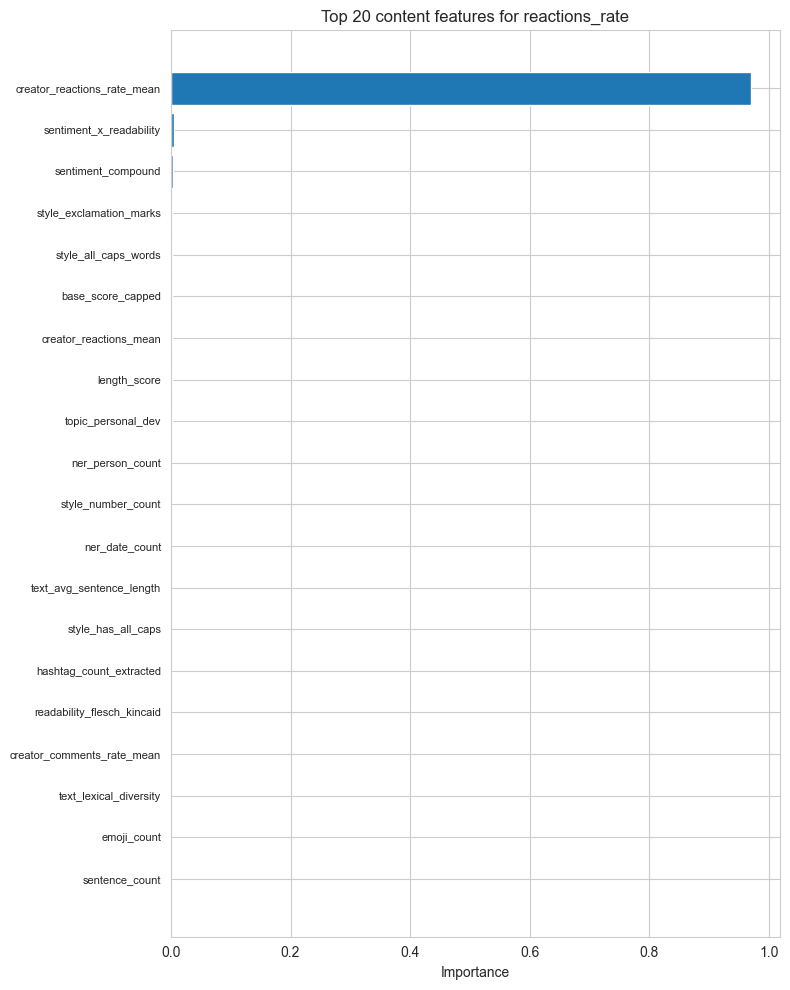

In [8]:
# 7. Diagnostics: follower dominance & feature importances

# Correlation of targets with followers and influencer stats
influencer_corr_cols = [
    c for c in [
        "followers",
        "influencer_post_count",
        "influencer_avg_engagement",
        "influencer_total_engagement",
    ]
    if c in df.columns
]

print("Influencer-like columns considered:", influencer_corr_cols)

corr_rows = []
for tcol in [
    "reactions", "comments",
    "reactions_rate", "comments_rate",
    "log_reactions", "log_comments",
    "reactions_rate_z_within_creator", "comments_rate_z_within_creator",
    "reactions_rate_pct_within_creator", "comments_rate_pct_within_creator",
]:
    if tcol not in df.columns:
        continue
    row = {"target": tcol}
    for icol in influencer_corr_cols:
        row[f"corr_with_{icol}"] = df[tcol].corr(df[icol])
    corr_rows.append(row)

corr_df = pd.DataFrame(corr_rows)
print("\nCorrelation of targets with influencer variables:")
print(corr_df)

# Simple feature importance for best tree-based model on content-only features
best_tree_model_name = "RandomForest"

# Re-train RandomForest on content-only features for interpretability
rf_content = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
)

rf_content.fit(X_content_train, train_df[TARGET_COL].values)
importances = rf_content.feature_importances_

fi_df = pd.DataFrame({
    "feature": CONTENT_FEATURES,
    "importance": importances,
}).sort_values("importance", ascending=False)

print("\nTop 20 content features for", TARGET_COL)
print(fi_df.head(20))

plt.figure(figsize=(8, 10))
fi_top = fi_df.head(20).iloc[::-1]
plt.barh(range(len(fi_top)), fi_top["importance"])
plt.yticks(range(len(fi_top)), fi_top["feature"], fontsize=8)
plt.xlabel("Importance")
plt.title(f"Top 20 content features for {TARGET_COL}")
plt.tight_layout()
plt.show()

In [9]:
# 8. Scoring helper: follower-robust content score

# For now we use the RandomForest trained on content-only features for TARGET_COL (reactions_rate)
# as a candidate content scoring model.

content_model = rf_content
content_feature_names = CONTENT_FEATURES


def score_post_content(feature_row: pd.Series) -> float:
    """Return predicted target (e.g., reactions_rate) for a single post.

    feature_row should contain at least the columns in content_feature_names.
    """
    x = feature_row.reindex(content_feature_names).fillna(0).values.reshape(1, -1)
    pred = content_model.predict(x)[0]
    return float(pred)


# Example usage on a few test rows
example_rows = df.iloc[test_idx].head(3)
print("Example content scores on first 3 test posts:")
for idx, row in example_rows.iterrows():
    s = score_post_content(row)
    print(f"Row {idx}: predicted {TARGET_COL} = {s:.4f}, actual = {row[TARGET_COL]:.4f}")

Example content scores on first 3 test posts:
Row 538: predicted reactions_rate = 0.0327, actual = 0.0324
Row 213: predicted reactions_rate = 0.0002, actual = 0.0002
Row 361: predicted reactions_rate = 0.0105, actual = 0.0106
